In [24]:
from pyspark.sql.types import *
import pandas as pd
import pyspark 
import os 
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, regexp_replace, col, sum as spark_sum
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
# Start a Spark session
spark = SparkSession.builder.appName("s33ding").getOrCreate()

## Start a Spark session
df = spark.read.csv("dataset/enem.csv", header=True, inferSchema=True)

In [9]:
df.dtypes

[('NU_ANO', 'double'),
 ('NU_INSCRICAO', 'bigint'),
 ('TP_FAIXA_ETARIA', 'string'),
 ('Idade_Calculada', 'string'),
 ('TP_SEXO', 'string'),
 ('TP_ESTADO_CIVIL', 'string'),
 ('TP_COR_RACA', 'string'),
 ('TP_NACIONALIDADE', 'string'),
 ('TP_ST_CONCLUSAO', 'string'),
 ('TP_ANO_CONCLUIU', 'string'),
 ('TP_ESCOLA', 'string'),
 ('TP_ENSINO', 'string'),
 ('TP_DEPENDENCIA_ADM_ESC', 'string'),
 ('TP_LOCALIZACAO_ESC', 'string'),
 ('TP_SIT_FUNC_ESC', 'string'),
 ('CO_UF_PROVA', 'double'),
 ('SG_UF_PROVA', 'string'),
 ('CO_MUNICIPIO_PROVA', 'double'),
 ('NO_MUNICIPIO_PROVA', 'string'),
 ('NOTA_CN_CIENCIAS_DA_NATUREZA', 'string'),
 ('NOTA_CH_CIENCIAS_HUMANAS', 'string'),
 ('NOTA_LC_LINGUAGENS_E_CODIGOS', 'string'),
 ('NOTA_MT_MATEMATICA', 'string'),
 ('NOTA_REDACAO', 'string'),
 ('NOTA_MEDIA_5_NOTAS', 'string'),
 ('TP_Lingua', 'string')]

In [10]:
df.show()

23/06/12 02:03:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+------------+----------------+---------------+---------+--------------------+-----------+--------------------+--------------------+---------------+-------------+--------------+----------------------+------------------+---------------+-----------+-----------+------------------+--------------------+----------------------------+------------------------+----------------------------+------------------+------------+------------------+---------+
|NU_ANO|NU_INSCRICAO| TP_FAIXA_ETARIA|Idade_Calculada|  TP_SEXO|     TP_ESTADO_CIVIL|TP_COR_RACA|    TP_NACIONALIDADE|     TP_ST_CONCLUSAO|TP_ANO_CONCLUIU|    TP_ESCOLA|     TP_ENSINO|TP_DEPENDENCIA_ADM_ESC|TP_LOCALIZACAO_ESC|TP_SIT_FUNC_ESC|CO_UF_PROVA|SG_UF_PROVA|CO_MUNICIPIO_PROVA|  NO_MUNICIPIO_PROVA|NOTA_CN_CIENCIAS_DA_NATUREZA|NOTA_CH_CIENCIAS_HUMANAS|NOTA_LC_LINGUAGENS_E_CODIGOS|NOTA_MT_MATEMATICA|NOTA_REDACAO|NOTA_MEDIA_5_NOTAS|TP_Lingua|
+------+------------+----------------+---------------+---------+--------------------+-----------+-

In [11]:
# List of columns to process as integers
cols_int = ["NU_ANO", "CO_UF_PROVA", "Idade_Calculada"]

# Iterate over each column name
for col_nm in cols_int:
    # Remove leading zeros from the column values
    df = df.withColumn(col_nm, regexp_replace(col(col_nm), "^0+", ""))
    # Convert the column to IntegerType
    df = df.withColumn(col_nm, df[col_nm].cast(IntegerType()))

# Remove decimal ".0" from CO_MUNICIPIO_PROVA column
df = df.withColumn("CO_MUNICIPIO_PROVA", regexp_replace(col("CO_MUNICIPIO_PROVA"), "\.0", ""))

# Drop the TP_Lingua column from the DataFrame
df = df.drop("TP_Lingua")

In [12]:
lst_float_data = [
    "NOTA_CN_CIENCIAS_DA_NATUREZA",
    "NOTA_CH_CIENCIAS_HUMANAS",
    "NOTA_LC_LINGUAGENS_E_CODIGOS",
    "NOTA_MT_MATEMATICA",
    "NOTA_REDACAO",
]

# Convert columns to FloatType()
for my_col in lst_float_data:
    df = df.withColumn(my_col, df[my_col].cast(FloatType()))


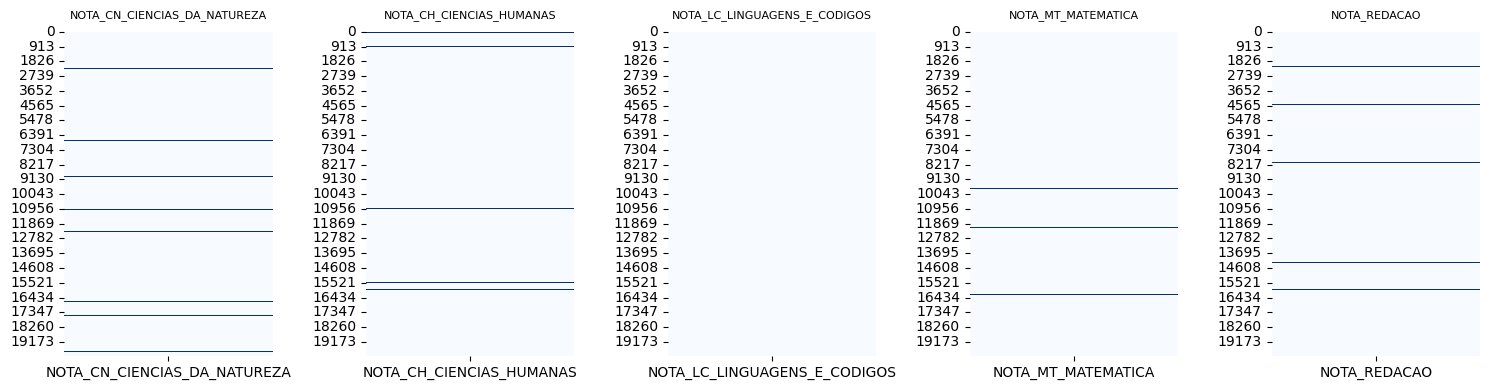

In [13]:
# Sample size
sample_size = 1000

# Create a subplot grid for the 5 graphs
fig, axes = plt.subplots(1, len(lst_float_data), figsize=(15, 4))

# Sample the desired columns and plot the heatmaps
for i, col_name in enumerate(lst_float_data):
    sampled_df = df.select([col_name]).withColumn(col_name, col(col_name).cast("integer")).sample(False, .05, seed=30)
    pandas_df = sampled_df.toPandas()
    ax = axes[i]
    sns.heatmap(data=pandas_df.isnull(), cmap="Blues", cbar=False, ax=ax, xticklabels=True)
    ax.set_title(col_name, pad=10, fontsize=8)

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()# Create a subplot grid for the 5 graphs


In [14]:
sum_grades_0 = df.filter((col("NOTA_MEDIA_5_NOTAS") != 0)).count()
sum_grades_nulls = df.filter((col("NOTA_MEDIA_5_NOTAS").isNull())).count()
print("total of 0 grades:", sum_grades_0)
print("total of null grades:", sum_grades_nulls )
df = df.filter((col("NOTA_MEDIA_5_NOTAS") != 0))

total of 0 grades: 374286
total of null grades: 0


In [15]:
for col_name in lst_float_data:
    df = df.filter(col(col_name) >= 0)

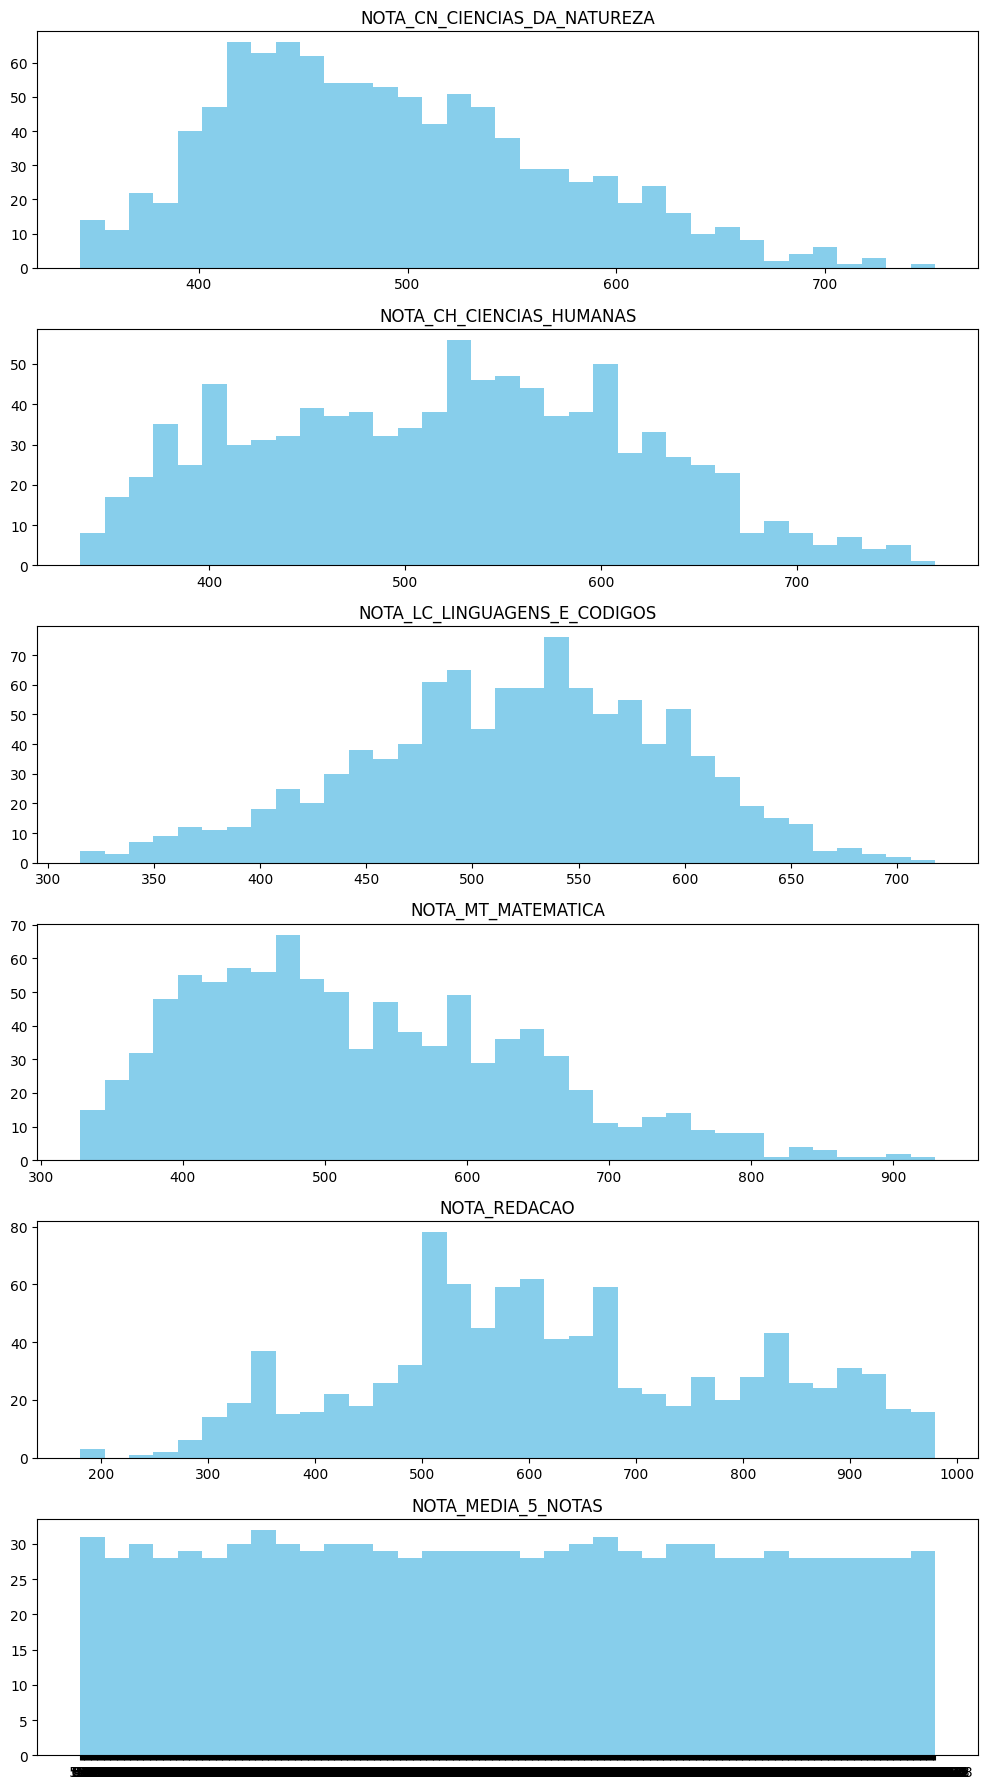

In [16]:
lst_float_data = [
    "NOTA_CN_CIENCIAS_DA_NATUREZA",
    "NOTA_CH_CIENCIAS_HUMANAS",
    "NOTA_LC_LINGUAGENS_E_CODIGOS",
    "NOTA_MT_MATEMATICA",
    "NOTA_REDACAO",
    "NOTA_MEDIA_5_NOTAS"
]

# Sample size
sample_size = 1000

# Sample the desired columns
sample_data = []
for column in lst_float_data:
    sampled_df = df.select(column).sample(False, sample_size/df.count())
    sample_data.append(sampled_df.toPandas()[column].values)

# Plot histograms for each column
fig, axs = plt.subplots(len(lst_float_data), figsize=(10,3* len(lst_float_data)))

for i, column in enumerate(lst_float_data):
    axs[i].hist(sample_data[i], bins=35, color='skyblue')
    axs[i].set_title(column)

plt.tight_layout()
plt.show()

In [17]:
lst_num_data = [
    "Idade_Calculada",
    "NOTA_CN_CIENCIAS_DA_NATUREZA",
    "NOTA_CH_CIENCIAS_HUMANAS",
    "NOTA_LC_LINGUAGENS_E_CODIGOS",
    "NOTA_MT_MATEMATICA",
    "NOTA_REDACAO",
    "NOTA_MEDIA_5_NOTAS"
]

summary_df = df.select(lst_num_data).describe()
summary_df.show()

+-------+------------------+----------------------------+------------------------+----------------------------+------------------+------------------+------------------+
|summary|   Idade_Calculada|NOTA_CN_CIENCIAS_DA_NATUREZA|NOTA_CH_CIENCIAS_HUMANAS|NOTA_LC_LINGUAGENS_E_CODIGOS|NOTA_MT_MATEMATICA|      NOTA_REDACAO|NOTA_MEDIA_5_NOTAS|
+-------+------------------+----------------------------+------------------------+----------------------------+------------------+------------------+------------------+
|  count|            374170|                      374170|                  374170|                      374170|            374170|            374170|            374170|
|   mean| 17.92046396023198|          493.59644731926915|       521.1264980634351|            517.945302691262| 528.3021420614084| 614.3744821872411| 534.9986846086008|
| stddev|3.5865535787918033|           81.11349810315832|       95.55287322810716|           75.98146943814588| 115.9383576589025|169.54324103897187| 88.02

In [18]:
for my_col in lst_num_data:
    print('col:',my_col)
    # Calculate the mean value for the column
    mean_val = df.agg({my_col: "mean"}).collect()[0][0]

    # Fill missing values with the mean
    df = df.na.fill(mean_val, [my_col])

col: Idade_Calculada


col: NOTA_CN_CIENCIAS_DA_NATUREZA


col: NOTA_CH_CIENCIAS_HUMANAS


col: NOTA_LC_LINGUAGENS_E_CODIGOS


col: NOTA_MT_MATEMATICA


col: NOTA_REDACAO


col: NOTA_MEDIA_5_NOTAS


In [19]:
df = df.withColumn("NOTA_MEDIA_5_NOTAS", (col("NOTA_CN_CIENCIAS_DA_NATUREZA") +
                                        col("NOTA_CH_CIENCIAS_HUMANAS") +
                                        col("NOTA_LC_LINGUAGENS_E_CODIGOS") +
                                        col("NOTA_MT_MATEMATICA") +
                                        col("NOTA_REDACAO")) / 5)

df = df.withColumn("NOTA_MEDIA_5_NOTAS", F.round(df["NOTA_MEDIA_5_NOTAS"], 2))
df.select(lst_float_data).show(3)

+----------------------------+------------------------+----------------------------+------------------+------------+------------------+
|NOTA_CN_CIENCIAS_DA_NATUREZA|NOTA_CH_CIENCIAS_HUMANAS|NOTA_LC_LINGUAGENS_E_CODIGOS|NOTA_MT_MATEMATICA|NOTA_REDACAO|NOTA_MEDIA_5_NOTAS|
+----------------------------+------------------------+----------------------------+------------------+------------+------------------+
|                       411.3|                   478.4|                       426.8|             351.2|       380.0|            409.54|
|                       440.0|                   459.3|                       571.7|             467.0|       900.0|             567.6|
|                       607.1|                   435.7|                       568.2|             414.7|       960.0|            597.14|
+----------------------------+------------------------+----------------------------+------------------+------------+------------------+
only showing top 3 rows



In [20]:
#rmv outliers
for my_col in lst_num_data:
    # Calculate values used for outlier filtering
    mean_val = df.agg({my_col: "mean"}).collect()[0][0]
    stddev_val = df.agg({my_col: "stddev"}).collect()[0][0]

    # Create three standard deviation (μ ± 3σ) lower and upper bounds for data
    low_bound = mean_val - (3 * stddev_val)
    hi_bound = mean_val + (3 * stddev_val)

    # Filter the data to fit between the lower and upper bounds
    df = df.where((df[my_col] < hi_bound) & (df[my_col] > low_bound))

In [21]:
df.show()

+------+------------+----------------+---------------+---------+--------------------+-------------+--------------------+--------------------+---------------+-------------+--------------+----------------------+------------------+---------------+-----------+-----------+------------------+--------------------+----------------------------+------------------------+----------------------------+------------------+------------+------------------+
|NU_ANO|NU_INSCRICAO| TP_FAIXA_ETARIA|Idade_Calculada|  TP_SEXO|     TP_ESTADO_CIVIL|  TP_COR_RACA|    TP_NACIONALIDADE|     TP_ST_CONCLUSAO|TP_ANO_CONCLUIU|    TP_ESCOLA|     TP_ENSINO|TP_DEPENDENCIA_ADM_ESC|TP_LOCALIZACAO_ESC|TP_SIT_FUNC_ESC|CO_UF_PROVA|SG_UF_PROVA|CO_MUNICIPIO_PROVA|  NO_MUNICIPIO_PROVA|NOTA_CN_CIENCIAS_DA_NATUREZA|NOTA_CH_CIENCIAS_HUMANAS|NOTA_LC_LINGUAGENS_E_CODIGOS|NOTA_MT_MATEMATICA|NOTA_REDACAO|NOTA_MEDIA_5_NOTAS|
+------+------------+----------------+---------------+---------+--------------------+-------------+---------------

In [25]:
# Count the occurrences of each value in the "NU_INSCRICAO" column
duplicate_counts = df.groupBy("NU_INSCRICAO").agg(count("*").alias("count"))

# Filter the duplicate values
duplicates = duplicate_counts.filter(col("count") > 1)

# Show the duplicate values
duplicates.show()

+------------+-----+
|NU_INSCRICAO|count|
+------------+-----+
+------------+-----+



In [26]:
df.coalesce(1).write.mode("overwrite").parquet("dataset/enem.parquet") 